
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/06_ConvNets.ipynb)

# Convolutional Networks: From Biology to Implementation

We've talked about the "MLP" architecture in previous lessons, in which inputs to the next layer of neurons are "fully connected" (everything is connected to everything else).

It turns out that for many applications in computer vision and signal processing, one can make great use of layers that look at only "local" (or "nearby") information, and then have the outputs of those be combined at successively larger spatial (or temporal) scales. This is what's known as a *local receptive field*, and is based directly on the biology of neurons in the visual cortex:

![neuron receptive field](https://i.imgur.com/KC4PsPc.png)
(Image source: http://neuroclusterbrain.com/neuron_model.html)

This idea was exploited in the ["Neocognitron" model](https://link.springer.com/article/10.1007/BF00344251) of Fukishima...

![fukushima image](https://media.licdn.com/dms/image/v2/D4E22AQF9y1Ch5f-SFw/feedshare-shrink_800/B4EZj6VggVIMAk-/0/1756546600720?e=1759363200&v=beta&t=K029kSwgUlsBFbb_jlsGmNfqm0rZvsHVtgDhqvfCpqs)

*(Image from a [recent LinkedIn thread on the history of ConvNets](https://www.linkedin.com/posts/j%C3%BCrgen-schmidhuber-39226872_convolutional-nns-cnns-are-widely-used-activity-7367490440830275586-AZPb?utm_source=share&utm_medium=member_desktop&rcm=ACoAAACBe-UB2-T8X7kp7cWQPeoyQ9qbeddrbrI) by Deep Learning pioneer Juergen Schmidthueber.)*

Fukushima was inspired by the Nobel-prize winning work of Hubel & Wiesel with cat vision, and how the different neurons in the cat brain learn to function as "pattern recognizers" for things like edges.
Here's a short video on Hubel & Wiesel's work:

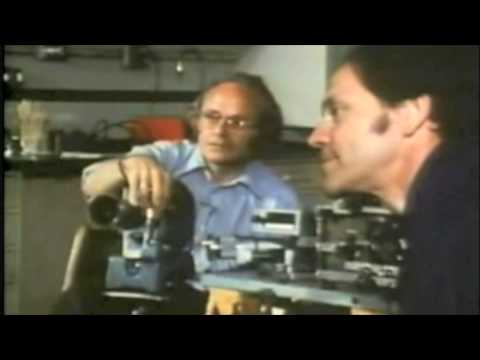

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('IOHayh06LJ4')

This work led to the development of the important "LeNet" architecture used by Yann LeCun and collaborators at Bell Labs, where this "local receptive field" is extended though multiple layers that "stack up" a increasingly "zoomed out" version of the image.  
![lenet arch image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/LeNet-5_architecture.svg/2880px-LeNet-5_architecture.svg.png) Image source: Wikipedia.

At each stage, multiple "filter banks" exist, which filter different parts of the image. As an illustration of this effect, consider this visualization of layer activations or "feature maps" at successive stages of a convolutional neural network being used for facial recognition:'

![layer feature maps](https://hedges.belmont.edu/scottergories/images/lee_et_all_faces.png)
(Image source: Lee et al, 2009)

Notice how the low-level features detect various kinds of edges (as with the cat neurons), which are combined via later layers in to "mid-level features" such as eyes and noses, and finally later layers for full face images.

## So what's convolution?

Convolution is a "running" dot product of a (typically smaller) vector or matrix called the "kernel" that is "run over" a larger vector or matrix representing a signal or image. The important point is that it's the SAME set of weights being applied *all over* the image. This is closely related to the notion that we often want our networks to be invariant to translations in space or time. An example you're probably familiar with is "running average", in which the kernel is a set of constant weights. A different example would be a "blur" filter used in photo editing, in which a weighted local average of nearby points becomes the new point.

The convolution kernel functions as a filter. In the interactive demo below, convolution kernel in the middle is "run over" each point of the input image, and then the dot product of the (local) image pixels and the kernel becomes the new pixel in the new image. Try clicking on the point in the 3x3 kernel, and notice how the shape of the kernel tends to match whats "allowed to pass through" the filter to make up the output image:

In [ ]:
from IPython.display import HTML, IFrame
print("Choose a kernel preset from the drop-down or click on the squares to create your own kernel.")
HTML('<iframe type="text/html" src="https://hedges.belmont.edu/~shawley/acts/demo/demo_draw.html" width="700px" height="280px" frameborder="0"></iframe>')

Choose a kernel preset from the drop-down or click on the squares to create your own kernel.


/Users/shawley/envs/dlaie/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


With this conceptual understanding under your belt, take a look at [this great medium post by Daphne Cornelisse](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/) to fill in more details of how convolution works -- note that we're going to use PyTorch code instead of Keras.

## Convolutions and Correlations

As another way to think about convolutions -- and to give a 1D example ("signal processing") instead the 2D ("computer vision") exercises we've been doing, here's another interactive Javascript demo you can try, in the input signal is "convolved" with the second "kernel" signal. The remainder of the demo shows the resulting filtered signal as well as the "correlation cofficient" -- which is the familiar correlation coefficient "R" from other areas of statistics & science! Notice that signals that "make it through" the kernel-filter are highly correlated, and vice versa.

In [ ]:
IFrame('https://hedges.belmont.edu/signal_corr_trans.html', width=800, height=650)

## Convolution (I/O) Math

Three paramaters determine output (image) dimension size $o$ given the input size $i$:

* `kernel_size` ($k$): how big the convolution kernel or "window" will be, in pixels
* `stride` ($s$): how many pixels to move between each kernel-image weighted sum
* `padding` ($p$): how many pixels to place in a border around the original image, to allow the convolution to output at all locations.

The following images and animations from [Aqeel Anwar's post on the subject](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11) show are illuminating:

![conv example](https://miro.medium.com/max/1250/1*gYAQUBj741P5-gbuboXfMA.png)
<table style="border:none">
    <tr>
        <td><img src="https://miro.medium.com/max/1250/1*YvlCSNzDEBGEWkZWNffPvw.gif"></td>
        <td><img  src="https://miro.medium.com/max/1250/1*gXAcHnbTxmPb8KjSryki-g.gif"></td>
    </tr>
        <td><img src="https://miro.medium.com/max/1250/1*gXAcHnbTxmPb8KjSryki-g.gif"></td>
        <td><img src="https://miro.medium.com/max/1250/1*34_365CJB5seboQDUrbI5A.gif"></td>
    <tr>
    </tr>
</table>

Given values for $k$, $s$, and $p$, then the output dimension $o$ (say, along one axis) in terms of input dimension $i$ is given by this equation:

$$ o = {i + 2p - k\over s} + 1\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1) $$
  

In [ ]:
# in code:
def calc_conv_output_size(input_size, kernel_size=3, stride=2, padding=1):
    return (input_size + 2 * padding - kernel_size) // stride + 1

# test it, shrink 4 times
x_size = 28        # initial image width or height
for i in range(4):
    x_size = calc_conv_output_size(x_size)
    print("x_size = ",x_size)

x_size =  14
x_size =  7
x_size =  4
x_size =  2


Depending on how we build our network, we may need to actually do that calculation to check our relative layer sizes, however below we'll do it in a way where we don't need to (by putting an "average pooling layer") near the end. ;-)


# MNIST MLP & CNN Demo

[MNIST](http://yann.lecun.com/exdb/mnist/) is a classic dataset of handwritten digits, which has been the testing ground for a [a variety of methods](https://en.wikipedia.org/wiki/MNIST_database)(Wikipedia) in machine learning.

![MNIST example](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

While Convolutional Neural Networks -- which we'll get to below -- tend to be most effective for image processing, the 28x28-pixel images in MNIST are small enough that we can apply the 'single hidden layer' model (also known as a Multi-Layer Perceptron or MLP) to it.  

Essentially, we will 'graduate' from the 7-segment display of digits from the previous lesson, to handwritten digits. Then we'll move on to larger, more diverse image datasets.

## Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [ ]:
# check that there's more than just the CPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
if device==torch.device('cpu'): print("You should probably restart this with a GPU. It will be slow otherwise.")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


## Dataset Selection and Configuration

Let's make our code flexible to work with different image classification datasets. We'll support several common datasets and automatically detect their properties.

In [ ]:
# Available datasets with their normalization parameters
DATASETS = {
    'MNIST': {
        'dataset_class': torchvision.datasets.MNIST,
        'mean': (0.1307,), 'std': (0.3081,),
        'description': '28x28 grayscale handwritten digits (0-9)'
    },
    'FashionMNIST': {
        'dataset_class': torchvision.datasets.FashionMNIST,
        'mean': (0.2860,), 'std': (0.3530,),
        'description': '28x28 grayscale fashion items (10 classes)'
    },
    'CIFAR10': {
        'dataset_class': torchvision.datasets.CIFAR10,
        'mean': (0.4914, 0.4822, 0.4465), 'std': (0.2023, 0.1994, 0.2010),
        'description': '32x32 color images (10 classes: planes, cars, etc.)'
    },
    'CIFAR100': {
        'dataset_class': torchvision.datasets.CIFAR100,
        'mean': (0.5071, 0.4867, 0.4408), 'std': (0.2675, 0.2565, 0.2761),
        'description': '32x32 color images (100 classes)'
    }
}

print("Available datasets:")
for name, info in DATASETS.items():
    print(f"  {name}: {info['description']}")


# Also let's let the user choose different activation functions, which will be implemented globally:
activations = { 'ReLU': nn.ReLU(), 'GELU': nn.GELU(),  'SiLU': nn.SiLU(), 'LeakyReLU': nn.LeakyReLU(0.01)}
print("\nAvailable activations:", activations.keys())

Available datasets:
  MNIST: 28x28 grayscale handwritten digits (0-9)
  FashionMNIST: 28x28 grayscale fashion items (10 classes)
  CIFAR10: 32x32 color images (10 classes: planes, cars, etc.)
  CIFAR100: 32x32 color images (100 classes)

Available activations: dict_keys(['ReLU', 'GELU', 'SiLU', 'LeakyReLU'])


In [ ]:
#### Your choices for dataset & activation functions
DATASET_NAME = 'MNIST'  # Change this to 'FashionMNIST', 'CIFAR10', or 'CIFAR100'
ACTIVATION_NAME = 'ReLU'  # Options: 'ReLU', 'GELU', 'SiLU', 'LeakyReLU'

ACTIVATION = activations[ACTIVATION_NAME]

print(f"\nUsing: {DATASET_NAME}")
print(f"Activation function: {ACTIVATION_NAME}")


Using: MNIST
Activation function: ReLU


## Data Loading and Preprocessing

Now we'll load the selected dataset and automatically detect its properties.

In [ ]:
def get_dataset_info(dataset_name):
    """Get dataset configuration and sample to determine properties."""
    config = DATASETS[dataset_name]
    basic_transform = transforms.Compose([transforms.ToTensor()])
    temp_dataset = config['dataset_class'](root='./data', train=True, download=True, transform=basic_transform)
    sample_img, _ = temp_dataset[0]

    return {
        'config': config,
        'num_channels': sample_img.shape[0],
        'img_height': sample_img.shape[1],
        'img_width': sample_img.shape[2],
        'num_classes': len(temp_dataset.classes),
        'class_names': temp_dataset.classes
    }

dataset_info = get_dataset_info(DATASET_NAME)

print(f"\nDataset Properties:")
print(f"  Image size: {dataset_info['num_channels']}x{dataset_info['img_height']}x{dataset_info['img_width']}")
print(f"  Number of classes: {dataset_info['num_classes']}")
print(f"  Classes: {dataset_info['class_names'][:10]}...")  # Show first 10 classes

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_info['config']['mean'], dataset_info['config']['std'])
])

train_dataset = dataset_info['config']['dataset_class'](root='./data', train=True, download=False, transform=transform)
test_dataset = dataset_info['config']['dataset_class'](root='./data', train=False, download=False, transform=transform)

batch_size = 128 # could make this bigger
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataset loaded:")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Test samples: {len(test_dataset):,}")


Dataset Properties:
  Image size: 1x28x28
  Number of classes: 10
  Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']...

Dataset loaded:
  Training samples: 60,000
  Test samples: 10,000


## Visualize Sample Data

Let's look at some examples from our dataset to understand what we're working with.

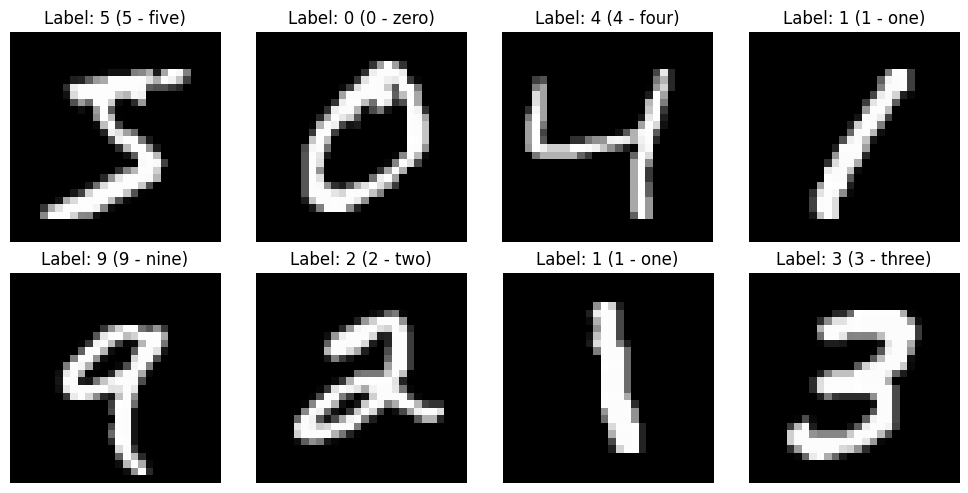

In [ ]:
def plot_samples(dataset, dataset_info, num_samples=8):
    """Visualize some sample images"""
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    axes = axes.ravel()
    mean, std = dataset_info['config']['mean'], dataset_info['config']['std']

    for i in range(num_samples):
        img, label = dataset[i]

        if len(mean) == 1:  # Grayscale
            img_denorm = img.squeeze() * std[0] + mean[0]
            axes[i].imshow(img_denorm, cmap='gray')
        else:  # Color
            img_denorm = img.clone()
            for c in range(len(mean)):
                img_denorm[c] = img_denorm[c] * std[c] + mean[c]
            img_denorm = torch.clamp(img_denorm, 0, 1).permute(1, 2, 0)  # (C,H,W) -> (H,W,C)
            axes[i].imshow(img_denorm)

        axes[i].set_title(f'Label: {label} ({dataset_info["class_names"][label]})')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_samples(train_dataset, dataset_info)

## Part 1: Multi-Layer Perceptron (MLP) Model

An MLP flattens the 2D image into a 1D vector and passes it through fully connected layers. This approach loses spatial information but is simpler to implement.

In [ ]:
class MLP(nn.Module):
    def __init__(self, dataset_info, hidden_sizes=[512, 256], dropout=0.2):
        super(MLP, self).__init__()

        input_size = (dataset_info['num_channels'] * dataset_info['img_height'] * dataset_info['img_width'])
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                ACTIVATION,
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, dataset_info['num_classes']))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))  # Flatten: (batch, C, H, W) -> (batch, C*H*W)

mlp_model = MLP(dataset_info).to(device)
print(f"MLP Model Parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

MLP Model Parameters: 535,818


### Understanding Dropout and Activation Functions

You'll notice we included `Dropout` layers and configurable activation functions in our MLP:

In [ ]:
nn.Dropout(0.2)  # 0.2 = 20% dropout rate - randomly sets 20% of neurons to zero during training

Dropout(p=0.2, inplace=False)

**Dropout** is only active during training - during evaluation/testing, all neurons are active but scaled appropriately. This prevents overfitting by forcing the network to not rely too heavily on specific neurons.

**Activation functions** introduce non-linearity. While ReLU is fast and simple, it can cause "dead neurons" that never activate. GELU and SiLU are smoother alternatives used in modern architectures like transformers.

## Training Function

We'll create a reusable training function that works for both models and logs metrics to wandb.

In [ ]:
def train_model(model, train_loader, test_loader, model_name, epochs=10, lr=0.001):
    # Initialize wandb
    wandb.init(project="convnet_tutorial", name=model_name+','+ACTIVATION_NAME, reinit=True)
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model_name,
        "optimizer": "Adam"
    })

    # Loss function:
    # Note: targets are just class indices (0-9), not one-hot vectors
    # nn.CrossEntropyLoss handles one-hot encoding internally for efficiency
    criterion = nn.CrossEntropyLoss()   # used for categorical variables, expects raw "logits"

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Use tqdm for progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()
            total_train += target.size(0)

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train

        # Evaluation phase
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct_test += pred.eq(target.view_as(pred)).sum().item()
                total_test += target.size(0)

        test_acc = 100. * correct_test / total_test

        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_loss,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc
        })

        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    wandb.finish()

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_test_acc': test_acc
    }

## Train the MLP Model

In [ ]:
print("Training MLP Model...")
start_time = time.time()
mlp_results = train_model(mlp_model, train_loader, test_loader, "MLP", epochs=10)
mlp_training_time = time.time() - start_time
print(f"MLP Training completed in {mlp_training_time:.2f} seconds")

Training MLP Model...


/Users/shawley/envs/dlaie/lib/python3.11/site-packages/wandb/sdk/launch/builder/build.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
wandb: Currently logged in as: drscotthawley. Use `wandb login --relogin` to force relogin


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 75.25it/s, Loss=0.1588, Acc=92.29%]


Epoch 1: Train Loss: 0.2549, Train Acc: 92.29%, Test Acc: 96.70%


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 79.87it/s, Loss=0.0415, Acc=96.65%]


Epoch 2: Train Loss: 0.1080, Train Acc: 96.65%, Test Acc: 97.24%


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 78.44it/s, Loss=0.0982, Acc=97.43%]


Epoch 3: Train Loss: 0.0828, Train Acc: 97.43%, Test Acc: 97.49%


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 79.70it/s, Loss=0.0229, Acc=97.94%]


Epoch 4: Train Loss: 0.0653, Train Acc: 97.94%, Test Acc: 98.09%


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 81.22it/s, Loss=0.0161, Acc=98.26%]


Epoch 5: Train Loss: 0.0534, Train Acc: 98.26%, Test Acc: 97.52%


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 82.84it/s, Loss=0.0381, Acc=98.54%]


Epoch 6: Train Loss: 0.0461, Train Acc: 98.54%, Test Acc: 97.82%


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 84.89it/s, Loss=0.0615, Acc=98.62%]


Epoch 7: Train Loss: 0.0436, Train Acc: 98.62%, Test Acc: 97.80%


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 84.17it/s, Loss=0.0208, Acc=98.72%]


Epoch 8: Train Loss: 0.0407, Train Acc: 98.72%, Test Acc: 98.40%


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 81.54it/s, Loss=0.0034, Acc=98.83%]


Epoch 9: Train Loss: 0.0349, Train Acc: 98.83%, Test Acc: 97.98%


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 81.20it/s, Loss=0.0078, Acc=98.92%]


Epoch 10: Train Loss: 0.0332, Train Acc: 98.92%, Test Acc: 98.22%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▃▄▇▄▆▆█▆▇
train_accuracy,▁▆▆▇▇█████
train_loss,█▃▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,98.22
train_accuracy,98.91667
train_loss,0.0332


MLP Training completed in 70.14 seconds


## Part 2: Convolutional Neural Network (CNN) Model

CNNs are specifically designed for image data. They use convolutional layers to detect local features and preserve spatial relationships, making them much more effective for image classification.

In [ ]:
class CNN(nn.Module):
    def __init__(self, dataset_info, base_channels=32, channel_mult=2, n_conv_layers=4):
        super(CNN, self).__init__()

        # Build conv layers dynamically
        self.conv_layers = nn.ModuleList()
        in_channels = dataset_info['num_channels']
        for i in range(n_conv_layers):
            out_channels = base_channels * (channel_mult ** i)
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
            in_channels = out_channels

        self.activation = ACTIVATION
        self.dropout1 = nn.Dropout(0.25)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) # put near end: yields one value per channel

        # Final channels after all conv layers
        final_channels = base_channels * (channel_mult ** (n_conv_layers - 1))
        self.fc = nn.Linear(final_channels, dataset_info['num_classes'])

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = self.activation(conv_layer(x))
            x = self.dropout1(x)
        x = self.global_avg_pool(x)  # one value per channel
        return self.fc(  x.flatten(start_dim=1) )  # flatten and run through linear layer



cnn_model = CNN(dataset_info).to(device)
print(f"CNN Model Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

# quick test to make sure the forward() runs w/o errors:
rnd_batch = torch.randn([128,dataset_info['num_channels'], dataset_info['img_height'], dataset_info['img_width']]).to(device)
result = cnn_model(rnd_batch)
del rnd_batch

CNN Model Parameters: 390,410


### Modern CNN Design and Activation Functions

Notice we use **strided convolutions** (stride=2) instead of pooling layers for spatial reduction. This is the modern approach because:
- The network can learn how to downsample rather than just taking the maximum value
- No information is discarded - the convolution learns optimal spatial reduction
- This is what you'll see in current architectures like ResNet and EfficientNet

**Activation function choices:**
- **ReLU**: Fast but can cause dead neurons that never activate again
- **GELU**: Smoother, used in transformers, better gradient flow
- **SiLU** (Swish): Self-gated, often outperforms ReLU in practice  
- **LeakyReLU**: Prevents dead neurons by allowing small negative values

Different activations can significantly impact training dynamics and final performance - experiment to see the differences!

## Train the CNN Model

In [ ]:
print("\nTraining CNN Model...")
start_time = time.time()
cnn_results = train_model(cnn_model, train_loader, test_loader, "CNN", epochs=10)
cnn_training_time = time.time() - start_time
print(f"CNN Training completed in {cnn_training_time:.2f} seconds")


Training CNN Model...


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 51.28it/s, Loss=0.0893, Acc=89.54%]


Epoch 1: Train Loss: 0.3378, Train Acc: 89.54%, Test Acc: 97.44%


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 54.34it/s, Loss=0.1055, Acc=96.69%]


Epoch 2: Train Loss: 0.1082, Train Acc: 96.69%, Test Acc: 98.09%


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 53.89it/s, Loss=0.0147, Acc=97.38%]


Epoch 3: Train Loss: 0.0820, Train Acc: 97.38%, Test Acc: 98.43%


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.73it/s, Loss=0.0491, Acc=97.97%]


Epoch 4: Train Loss: 0.0652, Train Acc: 97.97%, Test Acc: 98.76%


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.69it/s, Loss=0.0479, Acc=98.18%]


Epoch 5: Train Loss: 0.0572, Train Acc: 98.18%, Test Acc: 98.91%


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.65it/s, Loss=0.0134, Acc=98.38%]


Epoch 6: Train Loss: 0.0516, Train Acc: 98.38%, Test Acc: 98.86%


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.13it/s, Loss=0.0329, Acc=98.56%]


Epoch 7: Train Loss: 0.0454, Train Acc: 98.56%, Test Acc: 98.95%


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 58.04it/s, Loss=0.0930, Acc=98.67%]


Epoch 8: Train Loss: 0.0399, Train Acc: 98.67%, Test Acc: 98.98%


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 57.07it/s, Loss=0.0349, Acc=98.78%]


Epoch 9: Train Loss: 0.0363, Train Acc: 98.78%, Test Acc: 99.04%


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 57.03it/s, Loss=0.0086, Acc=98.82%]


Epoch 10: Train Loss: 0.0350, Train Acc: 98.82%, Test Acc: 99.14%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▄▅▆▇▇▇▇██
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,99.14
train_accuracy,98.81833
train_loss,0.03504


CNN Training completed in 100.37 seconds


## Results Comparison

Let's compare the performance of both models side by side.


FINAL RESULTS COMPARISON
Metric               MLP             CNN            
------------------------------------------------------------
Parameters           535818,,,,,,,,, 390410,,,,,,,,,
Training Time        70.14s           93.88s          
Final Test Acc       98.22%           99.00%          


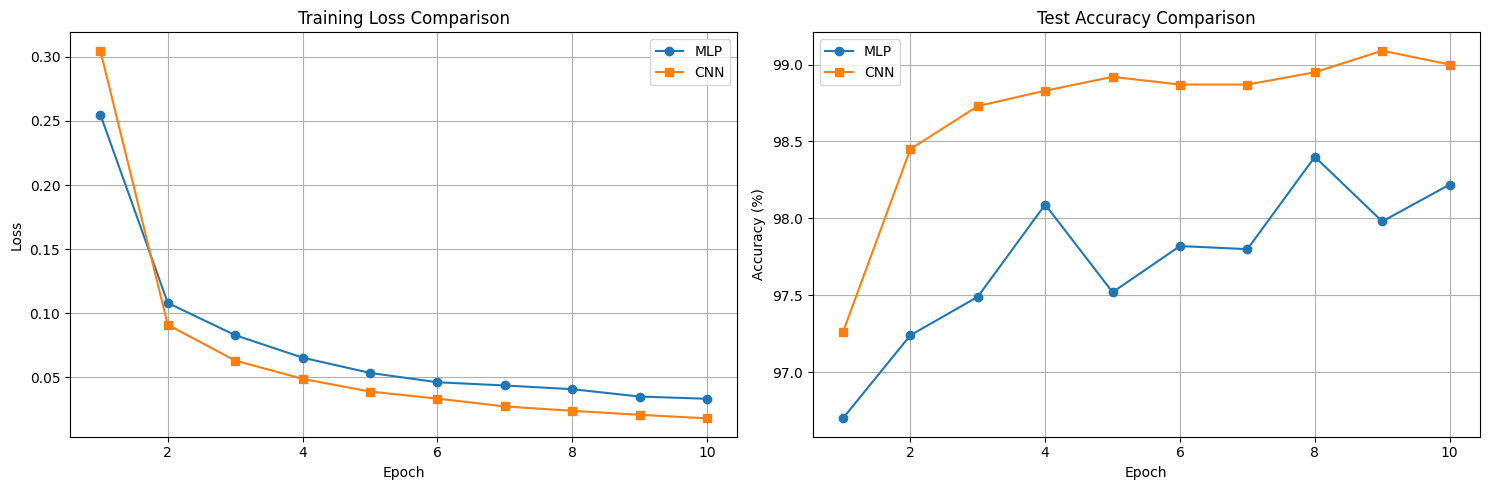

In [ ]:
# Print comparison results
print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'MLP':<15} {'CNN':<15}")
print("-" * 60)
print(f"{'Parameters':<20} {sum(p.numel() for p in mlp_model.parameters()):,<15} {sum(p.numel() for p in cnn_model.parameters()):,<15}")
print(f"{'Training Time':<20} {mlp_training_time:.2f}s{'':<10} {cnn_training_time:.2f}s{'':<10}")
print(f"{'Final Test Acc':<20} {mlp_results['final_test_acc']:.2f}%{'':<10} {cnn_results['final_test_acc']:.2f}%{'':<10}")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training loss comparison
epochs = range(1, 11)
ax1.plot(epochs, mlp_results['train_losses'], label='MLP', marker='o')
ax1.plot(epochs, cnn_results['train_losses'], label='CNN', marker='s')
ax1.set_title('Training Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Test accuracy comparison
ax2.plot(epochs, mlp_results['test_accuracies'], label='MLP', marker='o')
ax2.plot(epochs, cnn_results['test_accuracies'], label='CNN', marker='s')
ax2.set_title('Test Accuracy Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Model Evaluation and Analysis

Let's do a deeper analysis of our trained models.


MLP - Per-class Accuracies:
Digit 0: 99.29%
Digit 1: 99.38%
Digit 2: 97.58%
Digit 3: 99.01%
Digit 4: 96.64%
Digit 5: 97.87%
Digit 6: 98.54%
Digit 7: 98.54%
Digit 8: 96.92%
Digit 9: 98.22%

CNN - Per-class Accuracies:
Digit 0: 99.69%
Digit 1: 99.82%
Digit 2: 98.84%
Digit 3: 98.51%
Digit 4: 99.39%
Digit 5: 98.99%
Digit 6: 98.85%
Digit 7: 98.15%
Digit 8: 99.18%
Digit 9: 98.51%

Confusion Matrix Analysis:


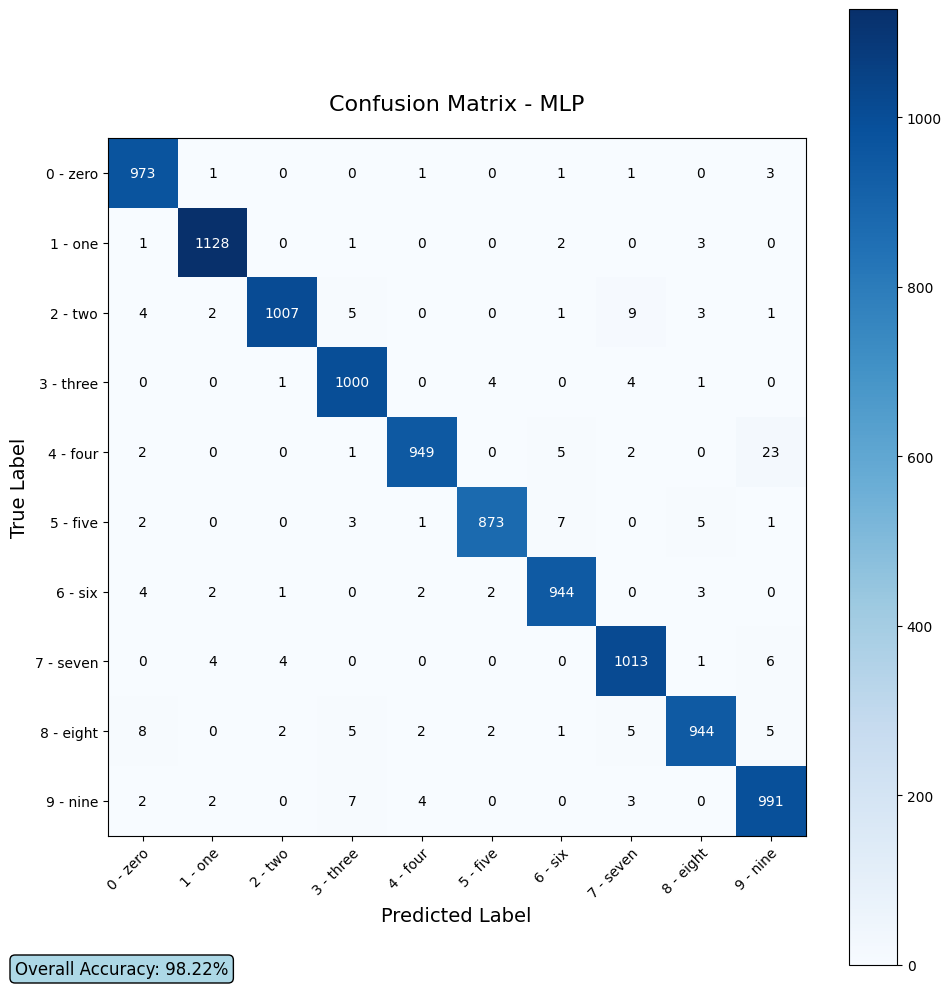

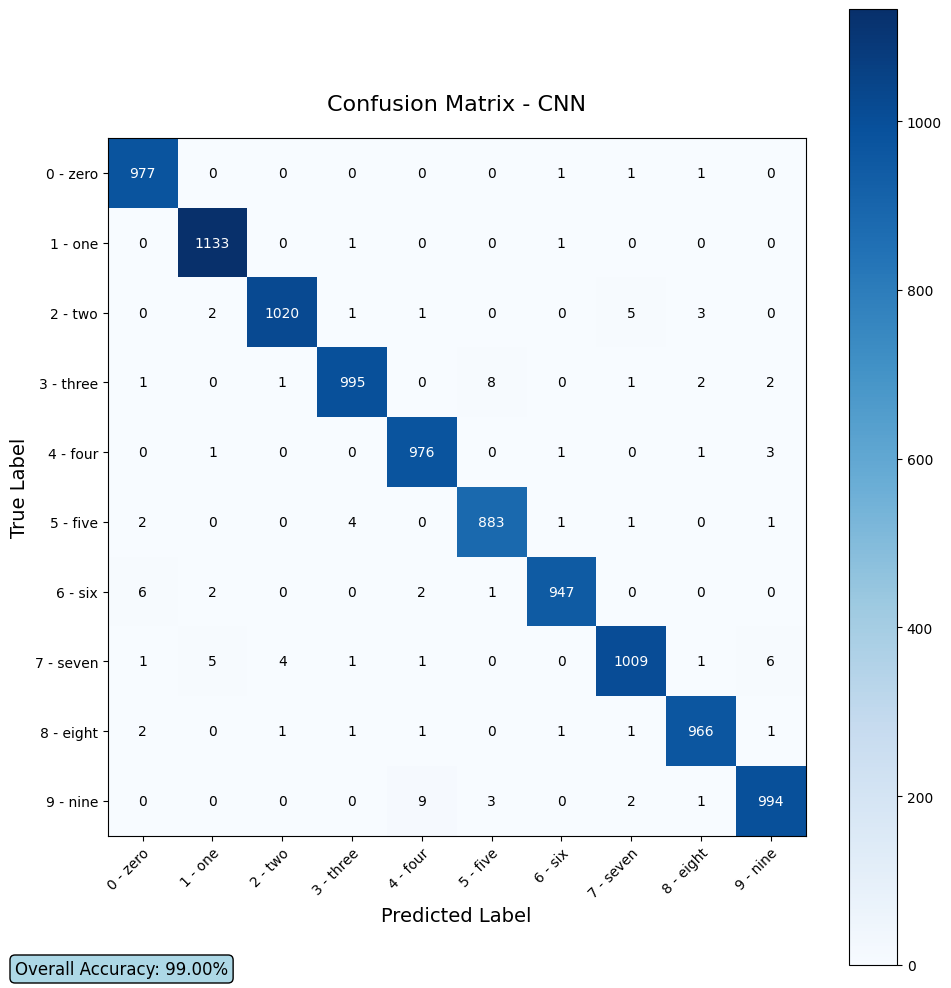

In [ ]:
def evaluate_model_detailed(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate per-class accuracy
    class_accuracies = []
    for i in range(10):
        mask = all_targets == i
        if mask.sum() > 0:
            class_acc = (all_preds[mask] == all_targets[mask]).mean() * 100
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)

    print(f"\n{model_name} - Per-class Accuracies:")
    for i, acc in enumerate(class_accuracies):
        print(f"Digit {i}: {acc:.2f}%")

    return all_preds, all_targets, class_accuracies

def plot_confusion_matrix(y_true, y_pred, model_name, class_names=None):
    """Plot confusion matrix with color-coded cells showing prediction counts."""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix
    fig, ax = plt.subplots(figsize=(max(8, len(cm)), max(6, len(cm))))  # Create plot
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Create heatmap
    plt.colorbar(im, ax=ax)  # Add colorbar

    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]

    # For datasets with many classes, show only every nth label
    if len(class_names) > 20:
        step = len(class_names) // 10
        tick_labels = [class_names[i] if i % step == 0 else '' for i in range(len(class_names))]
        tick_positions = range(len(class_names))
    else:
        tick_labels = class_names
        tick_positions = range(len(class_names))

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate labels

    # Add text annotations with counts (but only if not too many classes)
    if len(cm) <= 20:
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontsize=max(8, 12 - len(cm)//5))

    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)

    correct, total = np.trace(cm), np.sum(cm)  # Calculate accuracy
    accuracy = correct / total * 100

    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.2f}%',
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.tight_layout()
    plt.show()

mlp_preds, mlp_targets, mlp_class_acc = evaluate_model_detailed(mlp_model, test_loader, "MLP")  # Evaluate models
cnn_preds, cnn_targets, cnn_class_acc = evaluate_model_detailed(cnn_model, test_loader, "CNN")

print("\nConfusion Matrix Analysis:")  # Plot confusion matrices
plot_confusion_matrix(mlp_targets, mlp_preds, "MLP", class_names=dataset_info['class_names'])
plot_confusion_matrix(cnn_targets, cnn_preds, "CNN", class_names=dataset_info['class_names'])

## Visualizing Predictions

Let's look at some examples where the models made correct and incorrect predictions.

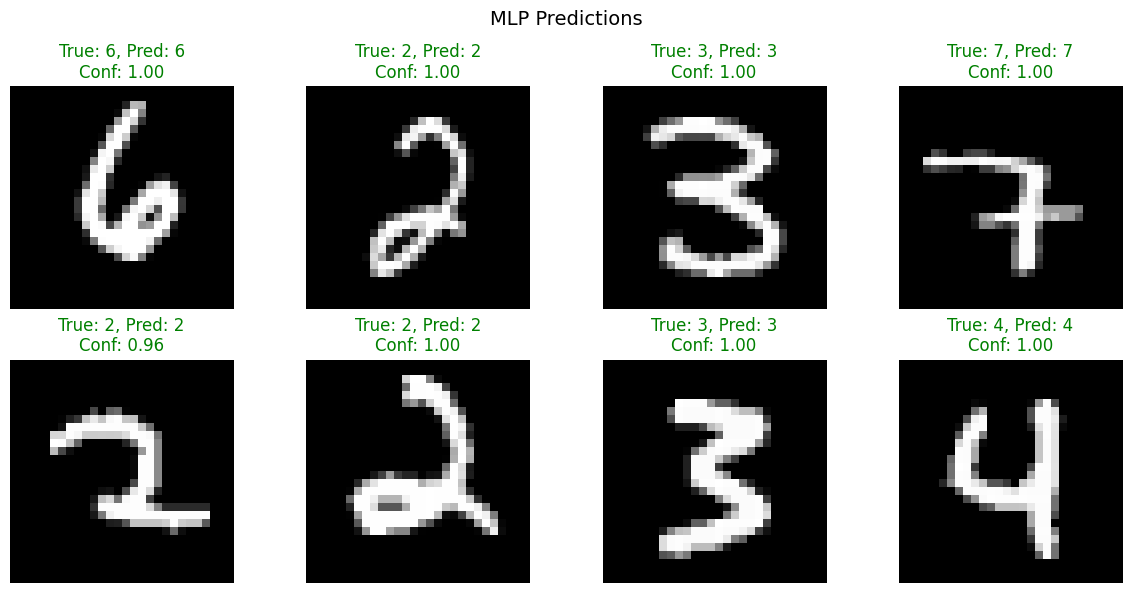

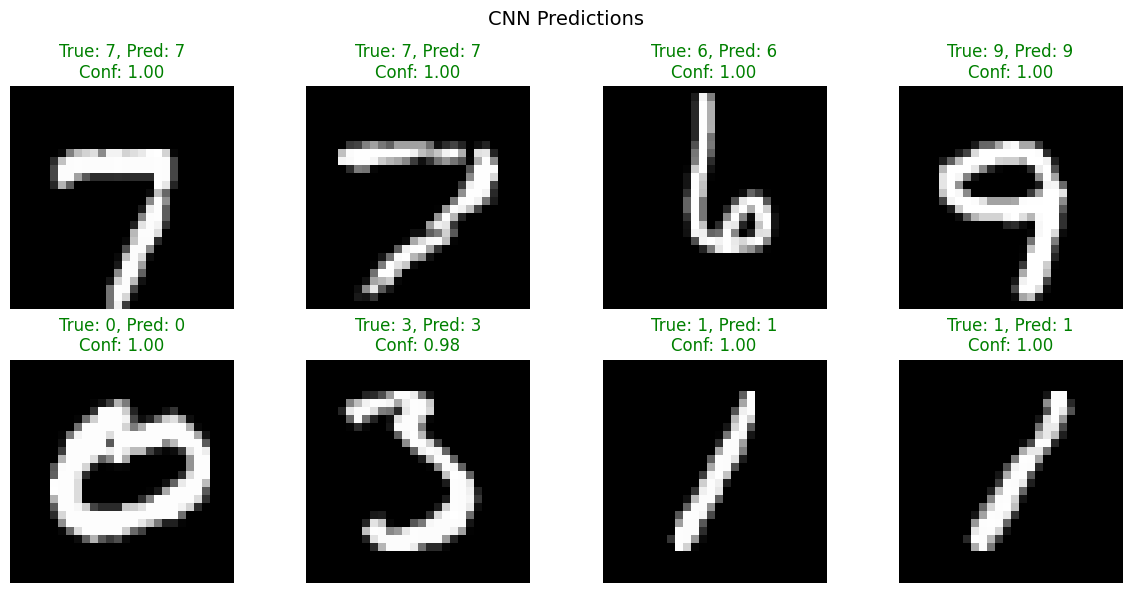

In [ ]:
def show_predictions(model, test_dataset, model_name, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    # Get some test samples
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, true_label = test_dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)

            output = model(img_tensor)
            pred_label = output.argmax(dim=1).item()
            confidence = F.softmax(output, dim=1).max().item()

            # Denormalize image for display
            display_img = img.squeeze() * 0.3081 + 0.1307

            axes[i].imshow(display_img, cmap='gray')

            # Color code: green for correct, red for incorrect
            color = 'green' if pred_label == true_label else 'red'
            axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}',
                             color=color)
            axes[i].axis('off')

    plt.suptitle(f'{model_name} Predictions', fontsize=14)
    plt.tight_layout()
    plt.show()

# Show predictions for both models
show_predictions(mlp_model, test_dataset, "MLP")
show_predictions(cnn_model, test_dataset, "CNN")

## Key Takeaways and Analysis

Based on our experiments, let's summarize the key findings:

In [ ]:
print("\n" + "="*80)
print("KEY INSIGHTS AND ANALYSIS")
print("="*80)

print("\n1. ACCURACY COMPARISON:")
print(f"   - CNN achieved {cnn_results['final_test_acc']:.2f}% accuracy")
print(f"   - MLP achieved {mlp_results['final_test_acc']:.2f}% accuracy")
print(f"   - CNN outperformed MLP by {cnn_results['final_test_acc'] - mlp_results['final_test_acc']:.2f} percentage points")

print("\n2. PARAMETER EFFICIENCY:")
mlp_params = sum(p.numel() for p in mlp_model.parameters())
cnn_params = sum(p.numel() for p in cnn_model.parameters())
print(f"   - MLP parameters: {mlp_params:,}")
print(f"   - CNN parameters: {cnn_params:,}")
print(f"   - CNN has {((cnn_params - mlp_params) / mlp_params * 100):+.1f}% parameters relative to MLP")


KEY INSIGHTS AND ANALYSIS

1. ACCURACY COMPARISON:
   - CNN achieved 99.14% accuracy
   - MLP achieved 98.22% accuracy
   - CNN outperformed MLP by 0.92 percentage points

2. PARAMETER EFFICIENCY:
   - MLP parameters: 535,818
   - CNN parameters: 390,410
   - CNN has -27.1% parameters relative to MLP


## Summary

In this lesson, we successfully implemented and compared two different neural network architectures for MNIST digit classification:

**Multi-Layer Perceptron (MLP):**
- Simple architecture with fully connected layers
- Treats images as flattened feature vectors
- Loses spatial information but computationally simpler

**Convolutional Neural Network (CNN):**
- Specialized architecture for image data
- Preserves spatial relationships through convolutions
- Uses hierarchical feature learning and parameter sharing

The CNN significantly outperformed the MLP, demonstrating why convolutional architectures are the gold standard for computer vision tasks. The CNN's ability to detect local features and build up complex representations makes it much more effective for image classification.

## Next Steps

To further improve performance, you could try:
1. **Data augmentation** (rotations, shifts, scaling)
2. **Advanced architectures** (ResNet, EfficientNet)
3. **Learning rate scheduling**
4. **Batch normalization**
5. **Transfer learning** from pre-trained models

The principles learned here extend to more complex vision tasks like object detection, segmentation, and beyond!

## Questions for Discussion:

1. If CNNs are supposed to be faster than MLPs for *most* applications, why is CNN training time similar on the MNIST dataset?
2. How might the results change if we used a larger, more complex dataset like CIFAR-10?
3. What would happen if we added batch normalization layers to our CNN?